# FSR Distribution

Copyright © 2022 Algorigo Inc. All Rights Reserved.


In [1]:
import os
import sys
import time
from datetime import datetime
import numpy as np
# import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
CURRENT_DATA = '220210/test1'
PATH_DATA_FSR = f'./dataset/{CURRENT_DATA}/fsr.csv'
PATH_DATA_KEY = f'./dataset/{CURRENT_DATA}/key.csv'

## FSR

In [3]:
df_fsr = pd.read_csv(PATH_DATA_FSR)
df_key = pd.read_csv(PATH_DATA_KEY)

# display( df_fsr.head() )
# display( df_key.head() )

__min = df_key.timestamp.min()
__max = df_key.timestamp.max()
df_fsr = df_fsr[ (df_fsr.timestamp >= __min) & (df_fsr.timestamp <= __max) ]

df_fsr.index = df_fsr.timestamp
# df_fsr = df_fsr.set_index('timestamp')
df_key = df_key.set_index('timestamp')
df_key_re = df_key.reindex(df_fsr.index, method='ffill') # nearest

df_fsr['key'] = df_key_re['key']
df_fsr = df_fsr.dropna(subset=['key']).reset_index(drop=True)
display( df_fsr.head() )
print( df_fsr.amp_sensor.unique() )
print( df_fsr.sens_sensor.unique() )

,timestamp,amp_sensor,sens_sensor,sensor,key
0,1644469530489,20,10,3264 0 568 0 0 748 1408 848 0 1980 3312 1472 0...,1
1,1644469530525,20,10,3228 0 556 0 0 744 1392 820 0 1980 3268 1436 0...,1
2,1644469530549,20,10,3276 0 592 0 0 732 1400 872 0 1964 3264 1440 0...,1
3,1644469530589,20,10,3276 0 592 0 0 712 1408 856 0 1984 3268 1456 0...,1
4,1644469530607,20,10,3324 0 592 64 0 712 1404 824 0 1996 3264 1440 ...,1


[20]
[10]


In [4]:
__meta = {'input': {'columns': ['sensor'],
  'shape': {'sensor': (32, 1)},
  'range': {'min': 0, 'max': 16383}},
 'reorder': {'shape': {'sensor': (8, 4)},
  'index': {'sensor': [1,
    5,
    20,
    24,
    2,
    6,
    19,
    23,
    3,
    7,
    18,
    22,
    4,
    8,
    17,
    21,
    9,
    13,
    28,
    0,
    10,
    14,
    27,
    31,
    11,
    15,
    26,
    30,
    12,
    16,
    25,
    29]}},
 'output': {'canvas': {'shape': (8, 4)},
  'offset': {'sensor': (0, 0)},
  'shape': {'sensor': (8, 8)}}}

def isNaN(value):
  return np.any( value != value )

def str_to_np_array(text):
  return np.array(text.strip().split(), dtype=np.float)

def np_array_to_str(values):
  return ' '.join('{0:.0f}'.format(val) for val in values)

def reorder(sensor_data, meta, interpolation=None): # back: 8x4, seat: 10x6
    result = {}
    if 'reorder' in meta:
        for col in meta['input']['columns']:
            if col not in sensor_data or sensor_data[col] is None:
               continue
            if isNaN(sensor_data[col]):
                continue
            __indexes = meta['reorder']['index']
            __shapes = meta['reorder']['shape']
            if col not in __indexes:
                result[col] = np.asarray(sensor_data[col]).reshape( meta['input']['shape'][col] )
            else:
                _index = np.asarray(__indexes[col])
                __s = sensor_data[col]
                if interpolation is not None:
                    _data =  np.asarray([ __s[x] if x >=0 else -1 for x in _index ]).reshape( __shapes[col] )
                    _data = cls.interpolate( _data ) #  meta['reorder']['shape'][col]
                else:
                    _data =  np.asarray([ __s[x] if x >=0 else 0 for x in _index ]).reshape( __shapes[col] )

                result[col] = _data
    else:
        result = sensor_data
    return result

def resize(sensor_data, meta):
    merged = np.zeros(meta['output']['canvas']['shape'], float)
    # merged = np.full(meta['output']['canvas']['shape'], -1, float)
    for col in meta['input']['columns']: # meta['input']['shape'][col]
        if col not in sensor_data or sensor_data[col] is None:
            continue
        if isNaN(sensor_data[col]):
            continue
        if 'resize' not in meta or sensor_data[col].shape == meta['resize']['shape'][col]:
            # printc(f'skip resize for {col}', color='green')
            _resized = sensor_data[col]
        else:
            # printc(f'resize for {col}', color='red')
            assert meta['resize']['shape'][col] == meta['output']['shape'][col]
            _resized = resize(
                sensor_data[col],
                meta['resize']['shape'][col],
                anti_aliasing=True
            )
        _position = meta['output']['offset'][col]
        _size     = meta['output']['shape'][col]
        merged[ _position[0]: _position[0] + _size[0], _position[1]: _position[1] + _size[1] ] = _resized
    return merged

def reorder_and_merge(data, meta, interpolation=None): # 'bilinear'
    sensor_data = {}
    for col in meta['input']['columns']:
        sensor_data[col] = data[col]
        if col not in sensor_data or sensor_data[col] is None:
            continue
        if isNaN(sensor_data[col]):
            continue
        if type(sensor_data[col]) == str:
            sensor_data[col] = np.array(sensor_data[col].strip().split(), dtype=np.float)
    _sensor = reorder( sensor_data, meta, interpolation)
    _output = resize( _sensor, meta)
    return _output

def plot_raw_by_each(data_frame, col, shape, row_width=5, max_count=50, interpolation='bilinear', title_col=None, vmin=0, vmax=4096):
    _df = data_frame

    assert row_width < 10
    printed_on_this_row = 0

    count = 0
    for index, data in _df.iterrows():
        count += 1
        if count > max_count:
            break

        _title = ""
        if title_col is not None:
            _title += f"{data[title_col]}\n"

        sensor_data = {}
        # for col in meta['input']['columns']:
        sensor_data[col] = data[col]
        if type(sensor_data[col]) == str:
            sensor_data[col] = np.array(sensor_data[col].strip().split(), dtype=np.float)
        else:
            sensor_data[col] = np.array(sensor_data[col])
        _title += f"--------------------\n[{col}]\n"
        _title += f"max:{int(np.max(sensor_data[col]))} "
        _title += f"min:{int(np.min(sensor_data[col]))}\n"
        _title += f"mean:{int(np.mean(sensor_data[col]))}\n"

        # _sensor = reorder( sensor_data, meta, True)
        # _output = resize( _sensor, meta)
        _output = sensor_data[col].reshape(shape) # meta['input']['shape']

        if index % row_width == 0:
            plt.figure(figsize=(20,10))
            printed_on_this_row = 0

        plt.subplot(101 + row_width * 10 + index % row_width)
        plt.imshow(
            _output,
            interpolation=interpolation,
            vmin=vmin,
            vmax=vmax,
            cmap=plt.cm.get_cmap('jet', 1000)  # RdBu_r, viridis
        )
        plt.grid(b=None)
        plt.axis('off')
        plt.title(_title)

        printed_on_this_row += 1

    # remaining columns in the last row (empty plot)

    if printed_on_this_row < row_width:
        _title = ''
        _output = np.zeros(shape, float)
        # _output = np.full(shape, -1, float)
        for index in list(range(row_width - printed_on_this_row)):
            plt.subplot(101 + row_width * 10 + index + printed_on_this_row)
            plt.imshow(_output, cmap='binary', vmin=0, vmax=1)
            plt.axis('off')
            plt.title(_title)
            # fig.axes.get_xaxis().set_visible(False)
            # fig.axes.get_yaxis().set_visible(False)
    plt.show()

### Plot Image

/var/folders/gl/bwp3gqbj4bv6jnt_yrcvd5800000gn/T/ipykernel_36275/2183807995.py:134: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sensor_data[col] = np.array(sensor_data[col].strip().split(), dtype=np.float)
/var/folders/gl/bwp3gqbj4bv6jnt_yrcvd5800000gn/T/ipykernel_36275/2183807995.py:158: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


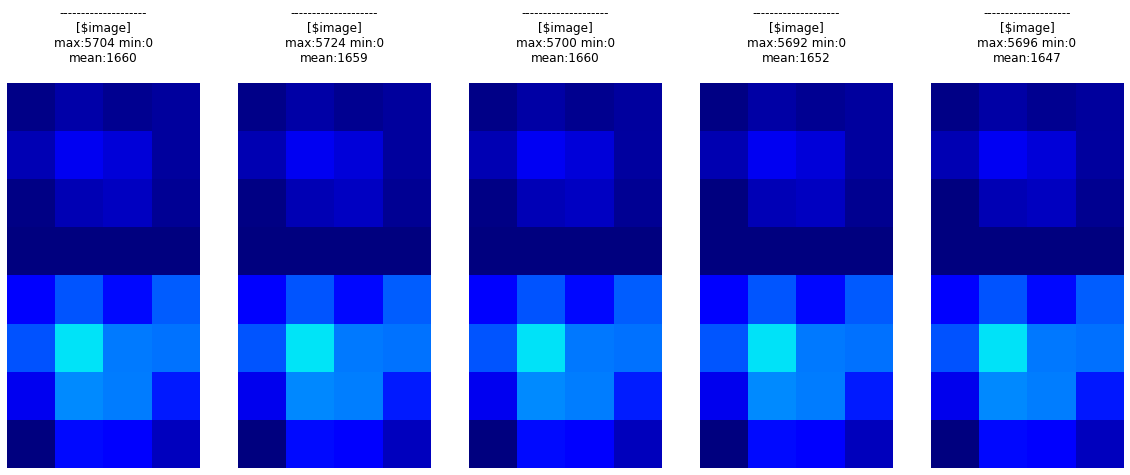

,timestamp,amp_sensor,sens_sensor,sensor,key,time_sec,$sensor,image,$image
0,1644469530489,20,10,"[3264.0, 0.0, 568.0, 0.0, 0.0, 748.0, 1408.0, ...",1,0.000,3264 0 568 0 0 748 1408 848 0 1980 3312 1472 0...,"[0.0, 748.0, 248.0, 240.0, 568.0, 1408.0, 1088...",0 748 248 240 568 1408 1088 272 0 848 768 72 0...
1,1644469530525,20,10,"[3228.0, 0.0, 556.0, 0.0, 0.0, 744.0, 1392.0, ...",1,0.036,3228 0 556 0 0 744 1392 820 0 1980 3268 1436 0...,"[0.0, 744.0, 244.0, 252.0, 556.0, 1392.0, 1084...",0 744 244 252 556 1392 1084 284 0 820 764 60 0...
2,1644469530549,20,10,"[3276.0, 0.0, 592.0, 0.0, 0.0, 732.0, 1400.0, ...",1,0.060,3276 0 592 0 0 732 1400 872 0 1964 3264 1440 0...,"[0.0, 732.0, 224.0, 188.0, 592.0, 1400.0, 1104...",0 732 224 188 592 1400 1104 304 0 872 780 60 0...
3,1644469530589,20,10,"[3276.0, 0.0, 592.0, 0.0, 0.0, 712.0, 1408.0, ...",1,0.100,3276 0 592 0 0 712 1408 856 0 1984 3268 1456 0...,"[0.0, 712.0, 176.0, 188.0, 592.0, 1408.0, 1092...",0 712 176 188 592 1408 1092 268 0 856 768 80 0...
4,1644469530607,20,10,"[3324.0, 0.0, 592.0, 64.0, 0.0, 712.0, 1404.0,...",1,0.118,3324 0 592 64 0 712 1404 824 0 1996 3264 1440 ...,"[0.0, 712.0, 176.0, 216.0, 592.0, 1404.0, 1088...",0 712 176 216 592 1404 1088 292 64 824 764 96 ...


In [5]:
df = df_fsr.copy()
df['time_sec'] = (df.timestamp - df.timestamp.min()) / 1000
df['$sensor'] = df['sensor']
df['sensor'] =  df['sensor'].apply(lambda x: np.array(x.split(' ')[:32], dtype=float))
df['image'] = df.apply(
    lambda x: reorder_and_merge(
        x, __meta # SENSOR_TYPE.CAR_SEAT_S1x32_RAW
    ).flatten(), axis=1
)
df['$image'] = df['image'].apply(lambda x: np_array_to_str(x))

plot_raw_by_each(df.iloc[2000:],
    '$image', (8,4),
    row_width=5, max_count=5, 
    interpolation=None, # 'bilinear',
    title_col=None,
    vmin=0, vmax=16383)

display( df.head() )

/var/folders/gl/bwp3gqbj4bv6jnt_yrcvd5800000gn/T/ipykernel_36275/2174494334.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indexes = np.concatenate([__meta['reorder']['index']['sensor']]).astype(np.int).reshape((8, 4))


[[ 117.64531289  590.71382637  253.60079149  429.58990848]
 [ 716.32945832 1659.88721247 1278.94830571  516.22656443]
 [ 182.97303982  908.13950037  956.18797922  348.71926787]
 [   0.            0.            0.            0.        ]
 [1978.87311402 3446.80385852 2174.2329953  3525.12589661]
 [3418.92752906 5702.66237942 3982.73361365 3870.63863468]
 [1601.87088795 4273.05169429 4035.6200841  2472.29878803]
 [   0.         2149.159535   1874.69502844  879.5894138 ]]


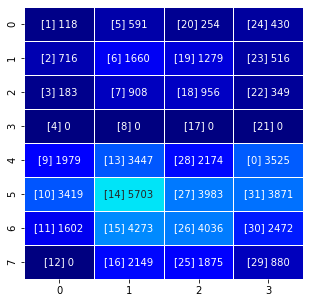

In [6]:
# reordered values
__image = np.mean( df.image.values, axis=0)
__max = np.max(__image)
__row = {'user_id': 'overall', 'image': __image }
__df = pd.DataFrame.from_records([__row])

# Annotated #

plt.figure(figsize=(5,5))

values = __df.iloc[0]['image'].reshape((8, 4))
print(values)
indexes = np.concatenate([__meta['reorder']['index']['sensor']]).astype(np.int).reshape((8, 4))
__labels = [f"[{i:1d}] {v:0.0f}" if i >= 0 else f"{v:0.0f}" for (v, i) in zip(values.reshape(32), indexes.reshape(32))]
__labels = np.asarray(__labels).reshape(8, 4)

__cmap = plt.cm.get_cmap('gist_gray') # inferno
__mask = values > 0  # condition to filter out

__cmap = plt.cm.get_cmap('jet', 1000)
# __mask = values <= 0

sns.heatmap(values,
            annot=__labels, fmt='',
            cmap=__cmap, vmin=0, vmax=16383, # __max,
            linecolor='white', linewidth=0.5,
            # mask=__mask,
            cbar=False)
plt.show()